# LeRobot Dataset Analysis

This notebook contains examples for analyzing and filtering the LeRobot dataset metadata CSV.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import json

# Read the CSV file
df = pd.read_csv('../lerobot_datasets.csv')

# Display basic information about the dataset
print("Dataset Shape:", df.shape)
df.info()

Dataset Shape: (3862, 22)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3862 entries, 0 to 3861
Data columns (total 22 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   repo_id                3862 non-null   object 
 1   username               3862 non-null   object 
 2   robot_type             3695 non-null   object 
 3   total_episodes         3862 non-null   int64  
 4   total_frames           3862 non-null   int64  
 5   fps                    3862 non-null   float64
 6   camera_keys            3802 non-null   object 
 7   num_cameras            3862 non-null   int64  
 8   video_keys             3577 non-null   object 
 9   has_video              3862 non-null   bool   
 10  total_tasks            3862 non-null   int64  
 11  tasks                  3862 non-null   object 
 12  is_sim                 3862 non-null   bool   
 13  is_eval                3862 non-null   bool   
 14  is_dAgger              3862 no

## Basic Filtering Examples

In [13]:
# Filter for datasets with significant data
qualified_datasets = df[
    (df['total_episodes'] >= 5) &  # At least 10 episodes
    (df['total_frames'] >= 1000) &  # At least 1000 frames
    (df['has_video'] == True) &     # Must have video
    (df['is_sim'] == False) &
    (df['is_eval'] == False) &
    ("test" not in df['repo_id'])
]

print(f"Original datasets: {len(df)}")
print(f"Qualified datasets: {len(qualified_datasets)}")

# Show distribution by robot type
print("\nDistribution by robot type:")
print(qualified_datasets['robot_type'].value_counts().head(20))

Original datasets: 3862
Qualified datasets: 1898

Distribution by robot type:
robot_type
so100              913
arx5_bimanual      291
koch               149
unknown             70
arx5                39
moss                35
aloha               31
franka              26
trossen_ai_solo     24
lekiwi              24
koch_bimanual       22
piper               18
mcx                 16
xarm                16
ur5                 14
so100_bimanual      12
apart               10
Unitree_G1           8
bi_ur5               7
so100_with_koch      6
Name: count, dtype: int64


## Analyzing Camera Configurations

In [3]:
# Look at camera configurations
camera_analysis = qualified_datasets.groupby(['robot_type', 'camera_keys']).size().reset_index(name='count')
print("Camera configurations by robot type:")
print(camera_analysis)

Camera configurations by robot type:
           robot_type                                        camera_keys  \
0              Franka   observation.images.head,observation.images.wrist   
1              Franka  observation.images.wrist_left,observation.imag...   
2                  G1  observation.images.third_person_cam,observatio...   
3    KIA Niro EV 2023  observation.images.front_left,observation.imag...   
4          Unitree_G1  observation.images.cam_left_high,observation.i...   
..                ...                                                ...   
313              xarm                      observation.images.hand_image   
314              xarm                           observation.images.image   
315              xarm  observation.images.image,observation.images.wr...   
316              xarm  observation.images.left_image,observation.imag...   
317            zenbot  observation.image.camera1,observation.image.ca...   

     count  
0        1  
1        1  
2        1 

## Dataset Size Analysis

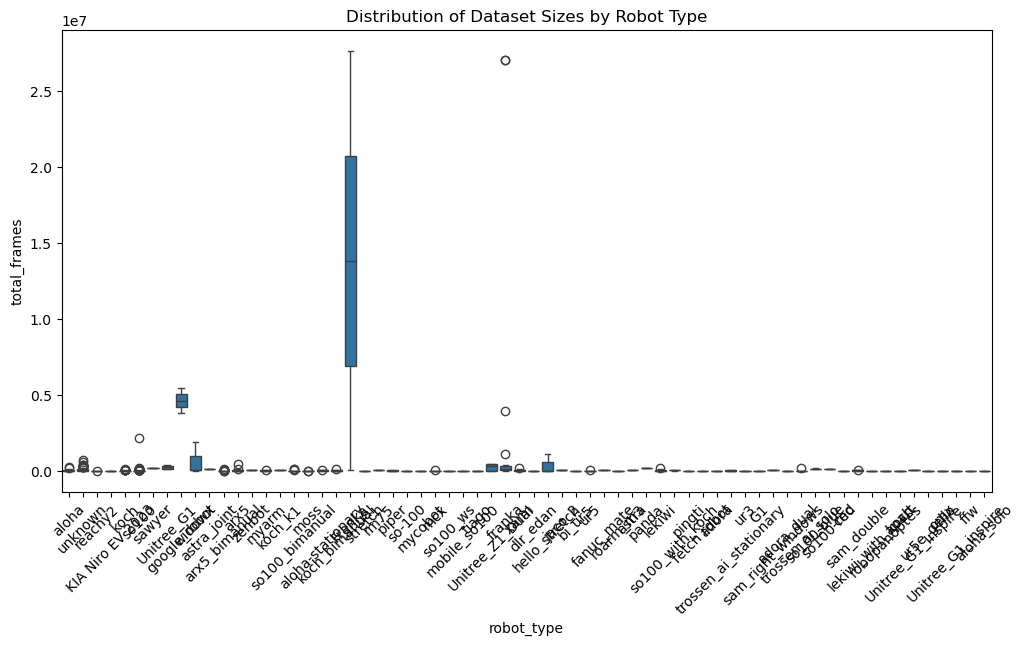

In [4]:
# Create size distribution plot
plt.figure(figsize=(12, 6))
sns.boxplot(data=qualified_datasets, x='robot_type', y='total_frames')
plt.xticks(rotation=45)
plt.title('Distribution of Dataset Sizes by Robot Type')
plt.show()

## Task Analysis

In [25]:
# Function to parse tasks JSON and check validity
def analyze_tasks(tasks_json):
    try:
        tasks = json.loads(tasks_json)
        valid_tasks = [task for task in tasks.values() 
                      if task and isinstance(task, str) and len(task.strip()) > 10]
        return len(valid_tasks) > 0
    except:
        return False

# Add task validity column
qualified_datasets['has_valid_tasks'] = qualified_datasets['tasks'].apply(analyze_tasks)

# Filter for datasets with valid tasks
valid_task_datasets = qualified_datasets[qualified_datasets['has_valid_tasks']]

print(f"Datasets with valid tasks: {len(valid_task_datasets)} out of {len(qualified_datasets)}")

Datasets with valid tasks: 866 out of 1000


/var/folders/vb/jgj22pc569n57n3jfn93xwj40000gp/T/ipykernel_85588/336862556.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  qualified_datasets['has_valid_tasks'] = qualified_datasets['tasks'].apply(analyze_tasks)


## User Contribution Analysis

In [26]:
# Analyze contributions by user
user_contributions = valid_task_datasets.groupby('username').agg({
    'repo_id': 'count',
    'total_episodes': 'sum',
    'total_frames': 'sum'
}).rename(columns={'repo_id': 'num_datasets'})

print("Top contributors by number of frames:")
print(user_contributions.sort_values('total_frames', ascending=False).head())

Top contributors by number of frames:
                 num_datasets  total_episodes  total_frames
username                                                   
IPEC-COMMUNITY             31          307810      47684081
cadene                      3           92335      27103617
lerobot                    69           55512       6691104
villekuosmanen            327            8712       4895372
unitreerobotics             8            2196       2394982


In [28]:
# filter by camera keys - datasets must have at least one camera key. so split based on comma and check if any are camera keys.
valid_cam_datasets = valid_task_datasets[valid_task_datasets['camera_keys'].apply(lambda x: len(x.split(',')) > 0)]
print(f"Datasets with camera keys: {len(valid_cam_datasets)} out of {len(df)}")

print("\nDistribution by robot type:")
print(qualified_datasets['robot_type'].value_counts())

Datasets with camera keys: 866 out of 1861

Distribution by robot type:
robot_type
so100               315
arx5_bimanual       291
koch                 79
unknown              74
arx5                 36
aloha                25
franka               22
moss                 21
koch_bimanual        20
piper                 8
Unitree_G1            8
piper_ros             7
mcx                   7
so100_bimanual        7
Unitree_Z1_Dual       5
reachy2               5
so-100                4
bi_ur5                4
mycobot               4
myarm                 4
aloha-stationary      3
hello_stretch         3
astra_joint           3
google_robot          2
so100_ws              2
mobile_so100          2
xarm                  2
ur5                   2
koch_k1               1
lekiwi                1
panda                 1
astra                 1
roarm_m3              1
fanuc_mate            1
stretch               1
jaco_2                1
zenbot                1
dlr_edan              1
sawye

## Export Filtered Results

In [11]:
# Export the final filtered dataset list
final_datasets = valid_cam_datasets[['repo_id', 'robot_type', 'total_episodes', 'total_frames', 'camera_keys']]
final_datasets.to_csv('qualified_datasets.csv', index=False)
print("Saved qualified datasets to 'qualified_datasets.csv'")

Saved qualified datasets to 'qualified_datasets.csv'
